# LangGraph doing a web search plus sentiment analysis using ReAct

* Sign up to: https://app.tavily.com/home
* Tavily search tool: https://python.langchain.com/docs/integrations/tools/tavily_search

In [ ]:
# %%capture --no-stderr
# %pip install langchain langchain-openai langchain_experimental python-dotenv matplotlib numpy pandas langgraph langchain-community langchain_tavily

In [3]:
import json
from dotenv import load_dotenv

load_dotenv()

def pp(data):
    print(json.dumps(data, indent=2, default=str))


In [4]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=5,
    topic="general", # Can be "general", "news", or "finance"
    # include_answer=False,
    # include_raw_content=False,
    include_images=False,
    include_image_descriptions=False,
    search_depth="basic",
    time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [ ]:
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent

llm = init_chat_model(
    "openai:gpt-5-nano"
)

# Decoramos nuestro llm con ReAct - Reason + Act
react_llm = create_react_agent(
    model=llm,
    tools=[tavily_search],
)

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    # ReAct usar `messages` para devolver el resultado de las tools que invoca
    response = react_llm.invoke({ "messages": [SystemMessage(content=prompt)] })

    return response

response = search_trending_topics({
    "user_query": "What are the latest trends in technology?",
    "refined_query": "Latest trends in technology",
    "trending_topics": "",
    "sentiment_analysis": ""
})

In [8]:
response

{'messages': [SystemMessage(content='\n    Given the refined user query, your job is to search for trending topics related to it.\n\n    Refined query: Latest trends in technology\n\n    Trending topics:', additional_kwargs={}, response_metadata={}, id='d5933c79-5f73-447f-ac54-aa2e44b71a72'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QCNNV69VQs3oUFngfG8UPinB', 'function': {'arguments': '{"query": "latest technology trends 2025", "search_depth": "advanced", "time_range": "year", "topic": "general"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_xIXORlO9N8S9gN1tFRqJEEO4', 'function': {'arguments': '{"query": "AI trends 2025 generative AI governance", "search_depth": "advanced", "time_range": "year", "topic": "general"}', 'name': 'tavily_search'}, 'type': 'function'}, {'id': 'call_jYOSZ9jZZ3srRMUZDnOW4fXA', 'function': {'arguments': '{"query": "quantum computing trends 2025", "search_depth": "advanced", "time_range": "year", "topic": "general"}'

In [10]:
response["messages"][-1].content.strip()

'Here are the latest technology trends making waves across industries right now, with a quick snapshot of why they’re hot and where to look for more details.\n\n- Generative AI and AI governance\n  - Why it’s trending: Generative AI is moving from pilot projects to widespread adoption, driving product innovation, content creation, and automation. At the same time, organizations are prioritizing responsible AI, ethics, and governance frameworks.\n  - Representative reads: WebPro News (2025 AI trends driving business innovation and sustainability), Mission Cloud (AI adoption stats and governance considerations), Yahoo Finance (Generative AI market growth and infrastructure needs).\n\n- AI as a core business strategy and AI infrastructure\n  - Why it’s trending: AI is being embedded into core workflows, customer experiences, and decision-making. This includes investments in AI hardware, platforms, and developer tooling to scale AI across the enterprise.\n  - Representative reads: Mission 

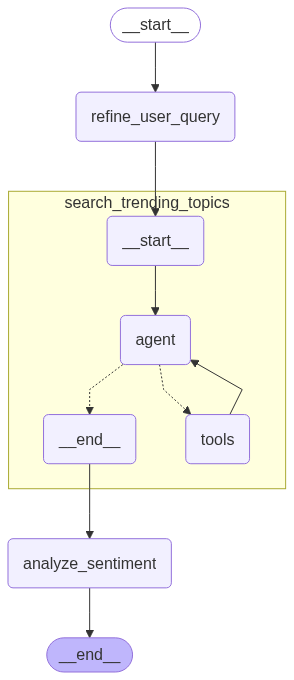

In [11]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model

from langgraph.prebuilt import create_react_agent

llm = init_chat_model(
    "openai:gpt-5-nano"
)

react_llm = create_react_agent(
    model=llm,
    tools=[tavily_search],
)

class TypedDictState(TypedDict):
    user_query: str
    refined_query: str
    trending_topics: str
    sentiment_analysis: str

def refine_user_query(state: TypedDictState) -> TypedDictState:
    user_query = state['user_query']

    prompt = f"""
    Given the user query, your job is to rewrite it to make it more specific and clear.

    User query: {user_query}

    Revised query:"""

    response = llm.invoke(prompt)

    return { "refined_query": response.content.strip() }

def search_trending_topics(state: TypedDictState) -> TypedDictState:
    refined_query = state['refined_query']

    prompt = f"""
    Given the refined user query, your job is to search for trending topics related to it.

    Refined query: {refined_query}

    Trending topics:"""

    response = react_llm.invoke({ "messages": [SystemMessage(content=prompt)] })

    return { "trending_topics": response["messages"][-1].content.strip() }

def analyze_sentiment(state: TypedDictState) -> TypedDictState:

    trending_topics = state['trending_topics']

    prompt = f"""
    Given the trending topics, your job is to analyze their sentiment.

    Trending topics: {trending_topics}

    Sentiment analysis:"""

    response = llm.invoke(prompt)

    return { "sentiment_analysis": response.content.strip() }

builder = StateGraph(TypedDictState)

builder.add_node("refine_user_query", refine_user_query)
builder.add_node("search_trending_topics", search_trending_topics)
builder.add_node("analyze_sentiment", analyze_sentiment)

builder.add_edge(START, "refine_user_query")
builder.add_edge("refine_user_query", "search_trending_topics")
builder.add_edge("search_trending_topics", "analyze_sentiment")
builder.add_edge("analyze_sentiment", END)

graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [12]:
initial_state : TypedDictState = {
    "user_query": "Is people buying ETH on the last month?",
    "refined_query": "",
    "trending_topics": "",
    "sentiment_analysis": ""
}

state = graph.invoke(input=initial_state)

In [13]:
state

{'user_query': 'Is people buying ETH on the last month?',
 'refined_query': 'Revised query: How many people bought Ethereum (ETH) in the last 30 days, and what was the total ETH purchase volume during that period?',
 'trending_topics': 'Here are trending topics related to your refined query about ETH buyers and purchase volume in the last 30 days, based on recent on-chain/business chatter and coverage:\n\n- ETH on-chain buyer activity trends (how many unique buyers or buying addresses occurred in the last 30 days)\n  - Why it’s trending: People are watching whether ETH demand is expanding as network activity and price move higher.\n  - Related coverage: Cryptorank notes rising on-chain activity, with daily transaction activity reaching elevated levels that often accompany increased buying pressure.\n\n- Total ETH purchase volume over the last 30 days (on-chain buy-volume)\n  - Why it’s trending: Analysts and traders want to quantify the amount of ETH being purchased, not just moved, to

In [14]:
from IPython.display import Markdown, display

display(Markdown(f"**Sentiment Analysis:**\n\n{state['sentiment_analysis']}"))


**Sentiment Analysis:**

Here’s a sentiment snapshot of the trending ETH-buyers and purchase-volume topics:

Overall vibe:
- The narrative is broadly cautiously optimistic: demand signals (on-chain buyers, purchase volume, and network activity) are favorable, but progress is tempered by data-definition debates and mixed institution flows.

Topic-by-topic sentiment:
- ETH on-chain buyer activity trends (unique buyers in last 30 days): Positive to cautiously optimistic. Rising buying activity suggests growing demand, but sustainability and the exact definition of “buyers” are key caveats.
- Total ETH purchase volume over the last 30 days (on-chain buy-volume): Positive/optimistic when framed by volume growth, though context matters. Traders want clear buy-intensity signals, and data quality or methodology nuances can mute enthusiasm.
- Institutional demand signals for ETH (ETF/institutional flows, custody, large-trader activity): Mixed. Pro-inflow signals (e.g., ETF inflows) would be positive, while outflows or ambiguous institutional activity keep sentiment uncertain.
- ETH network activity vs price dynamics (daily transactions, gas usage, and price correlation): Positive. Higher network activity aligned with price moves is viewed as a supportive sign for demand and potential price momentum.
- Methodology and definitions debate (how “buyers” and “purchase volume” are defined on-chain): Neutral/uncertain. This topic dampens conviction because differing definitions can lead to apples-vs-oranges comparisons.

What to watch next (implications):
- If unique buyers and purchase-volume both rise with consistent definitions, sentiment tilts more bullish.
- If institutional flows pivot (e.g., sustained inflows) or outflows dominate, sentiment could flip toward caution or bearish risk-off sentiment.
- Ongoing debates on methodology will keep short-term interpretation ranges wide; standardized metrics will improve clarity and confidence.

If you want, I can pull current figures from specific sources (e.g., Glassnode, Santiment, Nansen) and provide:
- number of unique ETH buying addresses in the last 30 days
- total ETH purchased (in ETH and USD if available)
- a quick comparison to the prior 30 days
I can also tailor the sentiment to your preferred definitions (e.g., only buyers that initiate purchases vs. all addresses receiving ETH via purchases) and by data source.